# Data Exploration for the Kaggle Competition on Rossmann Store Sales

## The idea

This Kaggle competition aims at predicting the sales of the Rossmann stores in a given period of time, given some information about them. The user is provided with three data sets:

1) A train dataset, containing historical data including sales

2) A test dataset, containing historial data excluding sales

3) Supplemental information about the stores (which can be easily merged with the train data set)

The goal of this file is to present a preliminary data exploration and identify some trends. An explanation of the variable meaning can be found on Kaggle:

https://www.kaggle.com/c/rossmann-store-sales/data

## General comments

There are **two main categories of variables**:

1) Time-independent: variables that do not depend on time, such as store ID, location, type of store, ect

2) Time-dependent: day of week, date, open, holiday, etc



## Summary of Results

This competition provides the user with a wealth of features (~15). However, our analysis shows that **many of the provided features are not strongly correlated with the store sales**. Furthermore, many features seem to contain the same information. For instance, the store ID, StoreType and Assortment features all contain information about how likely a particular store is to sell less/more than average. We therefore think that there is a **risk of significanlty overfitting the model**, if one does not choose carefully which features to use. Based on the exploratory analysis performed here (details shown below), **a good starting model should use only three features**, namely:

1) Store ID

2) DayOfWeek

3) Promo



In [1]:
%pylab inline
import csv as csv 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import datetime
from datetime import datetime
import seaborn
from time import time

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Reads the train and store data sets and merges them using Store column
data = pd.DataFrame.from_csv(open('/Users/dadda/Dropbox (MIT)/Kaggle Competitions/RSS/train.csv', 'rb',), index_col=None) 
extra_data = pd.DataFrame.from_csv(open('/Users/dadda/Dropbox (MIT)/Kaggle Competitions/RSS/store.csv', 'rb',), index_col=None) 
data = data[data.Open == 1]
concat = pd.merge(data, extra_data, on = 'Store')
test = pd.DataFrame.from_csv('/Users/dadda/Dropbox (MIT)/Kaggle Competitions/RSS/test.csv', index_col=None)


//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
# Does some cleaning, removes NaN's and zeros...
# I do nothing particularly fancy here; most of the columns have relatively few NaN anyways, so this makes no difference
concat.loc[(concat.Store.isnull()), 'Store'] = 0
concat.loc[(concat.SchoolHoliday.isnull()), 'SchoolHoliday'] = 0
concat.loc[(concat.StateHoliday.isnull()), 'StateHoliday'] = 0
concat.loc[(concat.Promo.isnull()), 'Promo'] = 0
concat.loc[(concat.CompetitionOpenSinceMonth.isnull()), 'CompetitionOpenSinceMonth'] = concat['CompetitionOpenSinceMonth'].mean()
concat.loc[(concat.CompetitionOpenSinceYear.isnull()), 'CompetitionOpenSinceYear'] = concat['CompetitionOpenSinceYear'].mean()
concat['Date2'] = pd.to_datetime(concat['Date']).dt.month
concat['StateHoliday2'] = concat['StateHoliday'].map( {'a': 1, 'b': 2, 'c': 3, '0': 0, 0:0} ).astype(int)
concat['StoreType2'] = concat['StoreType'].map( {'a': 1, 'b': 2, 'c': 3, 'd': 4} ).astype(int)
concat['Assortment2'] = concat['Assortment'].map( {'a': 1, 'b': 2, 'c': 3, 'd': 4} ).astype(int)

In [291]:
concat.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date2,StateHoliday2,StoreType2,Assortment2,Date3
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008,0,NaN,NaN,NaN,7,0,3,1,212
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,2008,0,NaN,NaN,NaN,7,0,3,1,211
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,2008,0,NaN,NaN,NaN,7,0,3,1,210
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,2008,0,NaN,NaN,NaN,7,0,3,1,209
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,2008,0,NaN,NaN,NaN,7,0,3,1,208


# Time-independent variables

In what follows, I will take a look at time-indipedent variables and check whether these correlate with the sale. Here are the findings:

1) One finds that there is a **strong correlation between the store ID and the sale**. Indeed, the store ID is one of the best predictors for the sale 

2) There is a clear dependence between the store type (there are 4) and sales

3) Similarly, there is a certain correlation between the store assortment and sale (though not a lot)

4) No clear trend is found between sales and the competitor's distance (not surprising)

We note that the first three variables do correlate with the sales. However, we also point out that these three variables are strongly correlated. In particular, the store ID (a unique ID for each store) probably already contains information about the type of store and assortment they have. So, as a first attempt, **we will ONLY consider the store ID** (and ignore the other time-independent variables) when modeling these data.

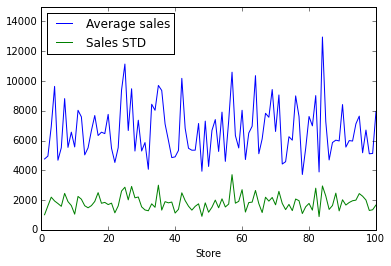

In [160]:
concat.groupby('Store')['Sales'].mean().plot(xlim = (0,100), ylim = (4000,15000), legend = True, label ='Average sales')
concat.groupby('Store')['Sales'].std().plot(xlim = (0,100), ylim = (0,15000), legend = True, label = 'Sales STD' )

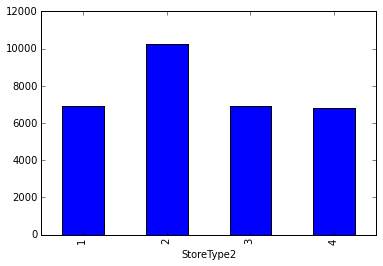

In [163]:
# The store type affects the sales type
concat.groupby('StoreType2')['Sales'].mean().plot(kind = 'bar')

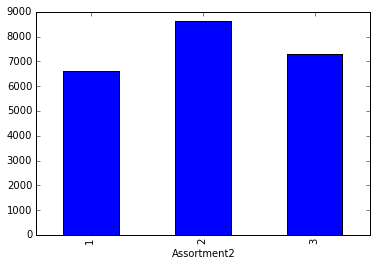

In [167]:
concat.groupby('Assortment2')['Sales'].mean().plot(kind = 'bar')

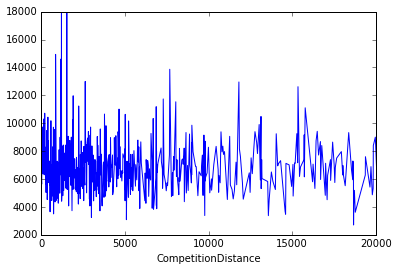

In [179]:
concat.groupby('CompetitionDistance')['Sales'].mean().plot(xlim = (0, 20000))

# Time-independent variables

There are many more time-dependent variables. Here I will explore some of them...

1) There is a clear trend with the DayOfWeek; curiously, Monday and Sunday (DayOfWeek = 1 or 7) are the days with the highest sales, while Saturday has the lowest. Also note that, since in Germany shops are usually closed on Sunday, only few stores are open on Sunday (~3000), which might explain the high sales on Sunday (those few stores that are open get a lot of customers)

2) If I transform the Date variable into the month, I find that there is a strong seasonal dependence of the sales. Indeed, sales are the highest in December and the lowest in January or during the Summer. One can similarly use the Date variable to extract the week of the year or even the day! The data thus obtained is quite noisy. However, when one uses the day of the year, some oscillations become apparent!

3) One can plot both the sales and promo variables (the latter rescaled ) vs the day of the year, one sees that there is a **clear and strong correlation between the oscillations in the sales and the promo variables**! In other words, promotions drive up sales significantly.

4) A similar analysis on SchoolHoliday and StateHoliday shows that there is little correlation with the sales (especially), little correlation that is not picked up by other variables. One exception is May 1st (Labour Day), when sales are the third highest in the year! One might think of engineering a variable that takes May 1st into account...

5) Finally, a simple analysis of the Promo2 and CompetitionOpen time intervals, does not really show any clear trend either...

In [60]:
concat.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date2,StateHoliday2,StoreType2,Assortment2,CompetitionOpenSinceDay,MonthYear,TimePassed
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,NaN,7,0,3,1,1,2008-09-01,7.139726
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,NaN,NaN,NaN,7,0,3,1,1,2008-09-01,7.139726
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,NaN,NaN,NaN,7,0,3,1,1,2008-09-01,7.139726
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,NaN,NaN,NaN,7,0,3,1,1,2008-09-01,7.139726
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,NaN,NaN,NaN,7,0,3,1,1,2008-09-01,7.139726


DayOfWeek  Open
1          1       137560
2          1       143961
3          1       141936
4          1       134644
5          1       138640
6          1       144058
7          1         3593
dtype: int64

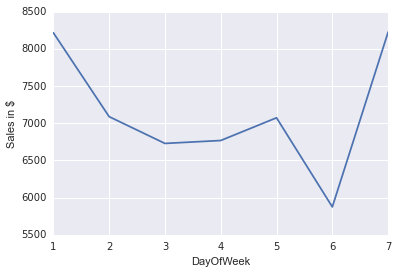

In [324]:
## Sale; only few stores are open on Sunday 
concat.groupby('DayOfWeek')['Sales'].mean().plot().set_ylabel("Sales in $")
concat.groupby(['DayOfWeek', 'Open'])['Open'].size()


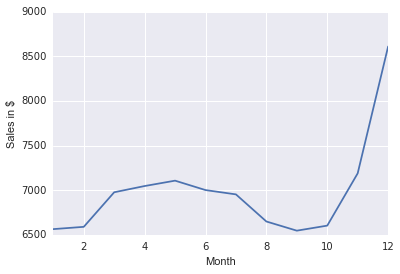

In [325]:
# Clear monthly dependence, with January and summer months showing the least sales
plt.figure()
concat.groupby('Date2')['Sales'].mean().plot()
plt.xlabel('Month')
plt.ylabel('Sales in $')
plt.show()


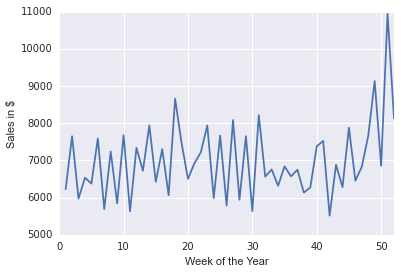

In [328]:
plt.figure()
concat['Date3'] = pd.to_datetime(concat['Date']).dt.weekofyear
concat.groupby('Date3')['Sales'].mean().plot(xlim = (0,52))
plt.xlabel('Week of the Year')
plt.ylabel('Sales in $')
plt.show()



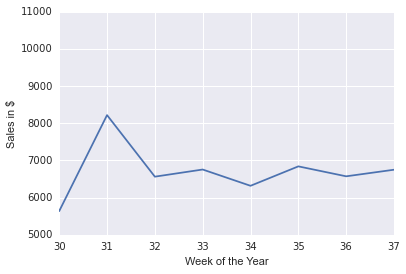

In [329]:
plt.figure()
concat['Date3'] = pd.to_datetime(concat['Date']).dt.weekofyear
concat.groupby('Date3')['Sales'].mean().plot(xlim = (30,37))
plt.xlabel('Week of the Year')
plt.ylabel('Sales in $')
plt.show()

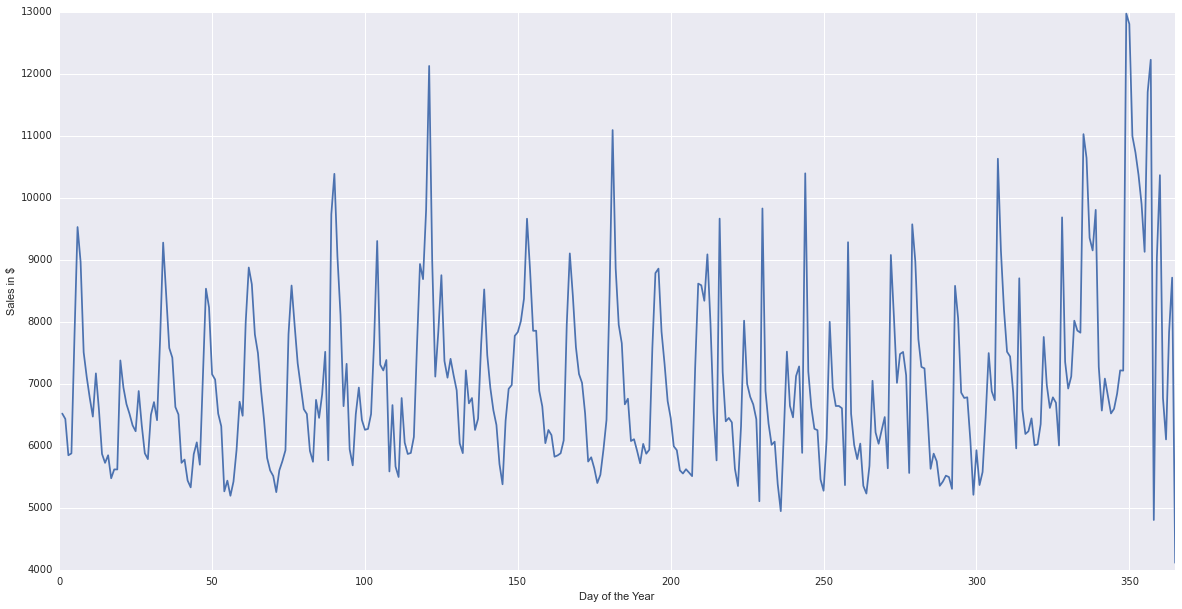

In [330]:
# Clear, nice oscillations observed in the data. 
# Their period is NOT one week, so they cannot be explained in terms of weekly-variability...

plt.figure(figsize=(20,10))
concat['Date3'] = pd.to_datetime(concat['Date']).dt.dayofyear
concat.groupby('Date3')['Sales'].mean().plot(xlim = (0,365))
plt.xlabel('Day of the Year')
plt.ylabel('Sales in $')
plt.show()



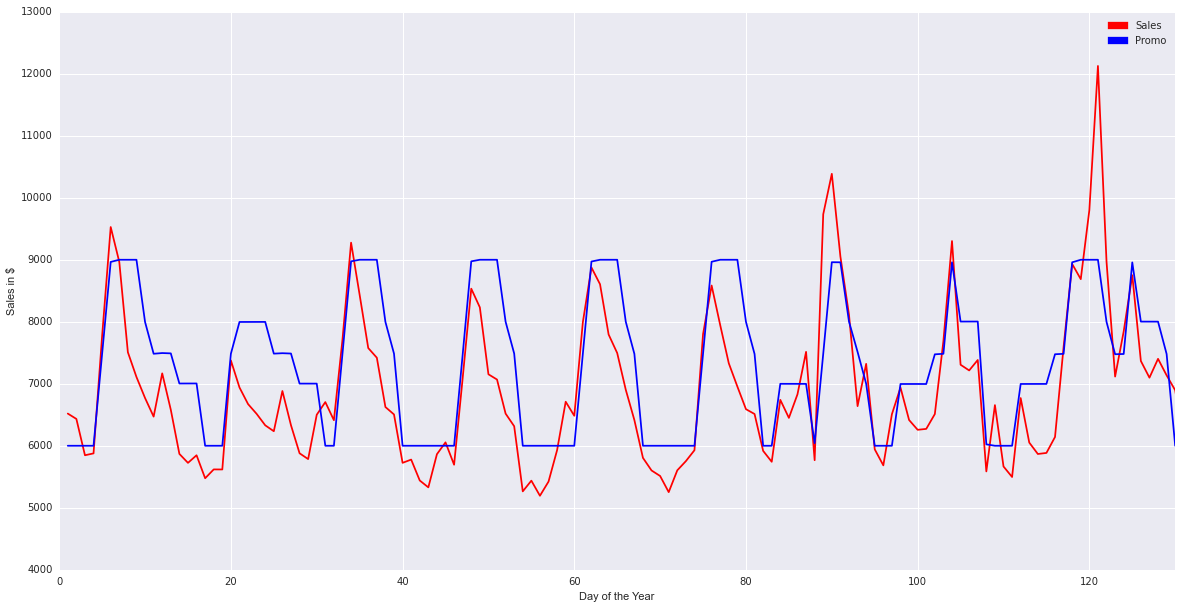

In [331]:
# Clear correlation between the oscillations in Sales and the promo code value

plt.figure(figsize=(20,10))
y = concat.groupby(['Date3'])['Sales'].mean()
z = 6000+3000*concat.groupby(['Date3'])['Promo'].mean()
x = concat.groupby(['Date3'])['Date3'].mean()
plt.plot(x, y, color = 'red', label = 'Sales')
plt.plot(x, z, color = 'blue')
plt.xlabel('Day of the Year')
plt.ylabel('Sales in $')
red_patch = mpatches.Patch(color='red', label='Sales')
blue_patch = mpatches.Patch(color='blue', label='Promo')
plt.legend(handles=[red_patch, blue_patch])
pylab.xlim([0,130])
plt.show()



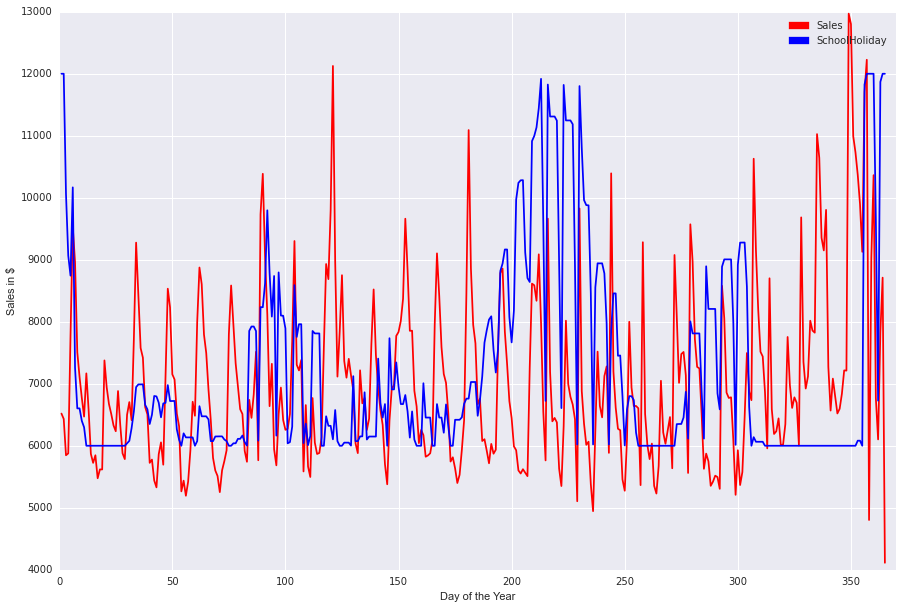

In [333]:
# No clear correlation between Sales and SchoolHoliday
plt.figure(figsize=(15,10))
y = concat.groupby(['Date3'])['Sales'].mean()
z = 6000+6000*concat.groupby(['Date3'])['SchoolHoliday'].mean()
x = concat.groupby(['Date3'])['Date3'].mean()
plt.plot(x, y, color = 'red', label = 'Sales')
plt.plot(x, z, color = 'blue')
plt.xlabel('Day of the Year')
plt.ylabel('Sales in $')
red_patch = mpatches.Patch(color='red', label='Sales')
blue_patch = mpatches.Patch(color='blue', label='SchoolHoliday')
plt.legend(handles=[red_patch, blue_patch])
pylab.xlim([0,370])
plt.show()


In [61]:
# No clear correlation between Sales and SchoolHoliday

plt.figure(figsize=(15,10))
y = concat.groupby(['Date3'])['Sales'].mean()
z = 6000+6000*concat.groupby(['Date3'])['StateHoliday2'].mean()
x = concat.groupby(['Date3'])['Date3'].mean()
plt.plot(x, y, color = 'red', label = 'Sales')
plt.plot(x, z, color = 'blue')
plt.xlabel('Day of the Year')
plt.ylabel('Sales in $')
red_patch = mpatches.Patch(color='red', label='Sales')
blue_patch = mpatches.Patch(color='blue', label='StateHoliday')
plt.legend(handles=[red_patch, blue_patch])
pylab.xlim([20,222])
plt.show()


KeyError: 'Date3'

In [314]:
# Labor Day has the fourth highest sales in the year!
concat.groupby(['Date3'])['Sales'].mean().order(ascending = False).head(5)


Date3
349    12969.971639
350    12802.247805
357    12225.453659
121    12125.517241
356    11704.693666
Name: Sales, dtype: float64

In [307]:
#Just to confirm, day 121 is May 1st

date_test = datetime.date(2018,05,01)
date_test.strftime('%j')


'121'

In [355]:
concat.groupby(['Promo2'])['Sales'].size()
concat['Promo2'].mean()

0.49868426039090846

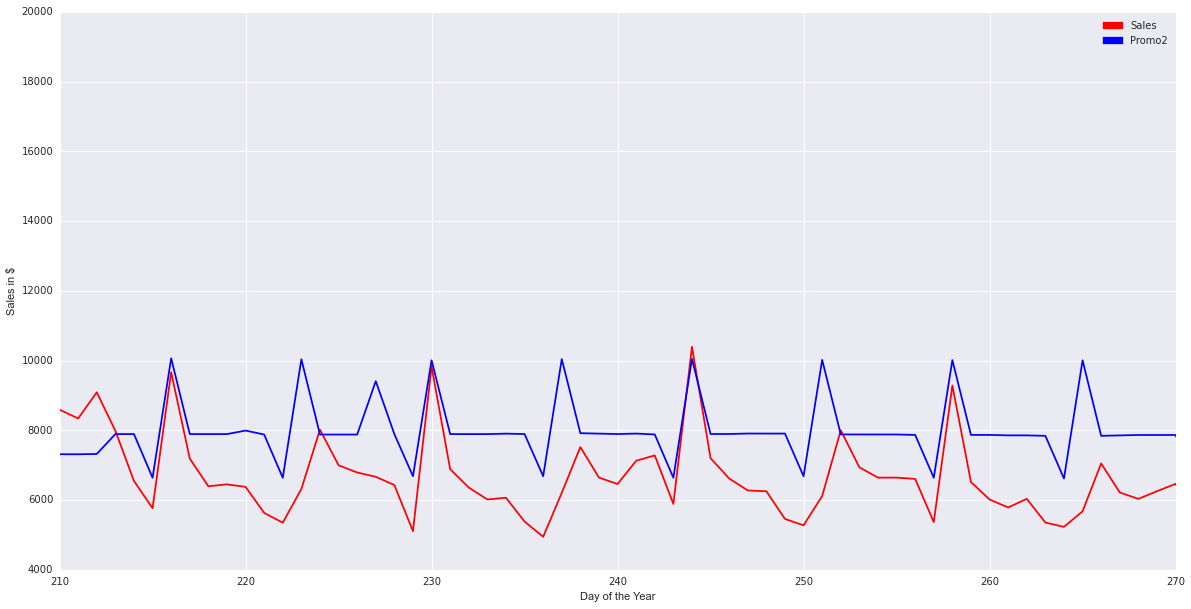

In [366]:
# During the summer months there is a very strong correlation between changes in Promo2 and Sales!!
# However, note that these changes follow a weekly pattern...
plt.figure(figsize=(20,10))
y = concat.groupby(['Date3'])['Sales'].mean()
z = 7000-50000*(concat.groupby(['Date3'])['Promo2'].mean()-0.498)
x = concat.groupby(['Date3'])['Date3'].mean()
w = concat.groupby(['DayOfWeek'])['Sales'].mean()
plt.plot(x, y, color = 'red', label = 'Sales')
plt.plot(x, z, color = 'blue')
#plt.plot(x, w, color = 'green')
plt.xlabel('Day of the Year')
plt.ylabel('Sales in $')
red_patch = mpatches.Patch(color='red', label='Sales')
blue_patch = mpatches.Patch(color='blue', label='Promo2')
plt.legend(handles=[red_patch, blue_patch])
pylab.xlim([210,270])
plt.show()

In [6]:
# Merging the year and month variables
concat['CompetitionOpenSinceYear'] = concat['CompetitionOpenSinceYear'].astype(int)
concat['CompetitionOpenSinceMonth'] = concat['CompetitionOpenSinceMonth'].astype(int)
concat['CompetitionOpenSinceDay'] = 1
#concat['CompetitionOpenSinceDay']
concat['Year'] = concat.apply(lambda row: datetime(row['CompetitionOpenSinceYear'], row['CompetitionOpenSinceMonth'], row['CompetitionOpenSinceDay']), axis=1)


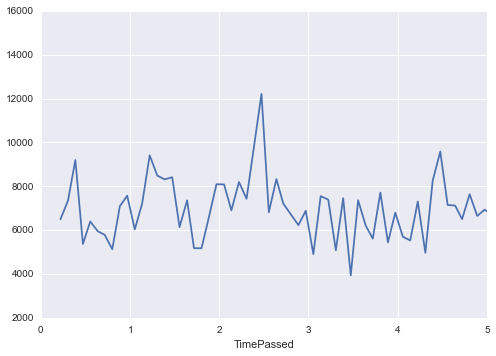

In [33]:
# No clear correlation bewteen the time passed since the nearest competitor opened and the sales (all I see is noise)
today = datetime.now()
concat['TimePassed'] = ((today - concat['MonthYear']).dt.days)/365
series = concat['TimePassed'].copy()
series = series.order(ascending=False)
concat.groupby('TimePassed')['Sales'].mean().plot(xlim = (0,5))

In [36]:
concat.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date2,StateHoliday2,StoreType2,Assortment2,CompetitionOpenSinceDay,MonthYear,TimePassed
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,NaN,7,0,3,1,1,2008-09-01,7.139726
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,NaN,NaN,NaN,7,0,3,1,1,2008-09-01,7.139726
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,NaN,NaN,NaN,7,0,3,1,1,2008-09-01,7.139726
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,NaN,NaN,NaN,7,0,3,1,1,2008-09-01,7.139726
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,NaN,NaN,NaN,7,0,3,1,1,2008-09-01,7.139726


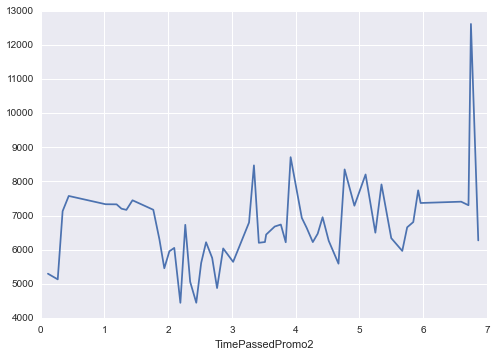

In [57]:
# Calculating a time-interval for the promo2; no clear,strong trend between this variable and sales...
data = concat.copy()
data = data.dropna()
data['Promo2SinceDay'] = 7*data['Promo2SinceWeek'].astype(int)
data['Promo2SinceYear'] = data['Promo2SinceYear'].astype(int)

data['TimePassedPromo2'] = (2015 - concat['Promo2SinceYear'])+data['Promo2SinceDay']/365
#data['TimePassedPromo2']
data.groupby('TimePassedPromo2')['Sales'].mean().plot(xlim = (0,7))

In [105]:
concat2 = concat[(concat.Date == 8) | (concat.Date == 9)]
concat2.groupby('PromoInterval')['Sales'].mean()

PromoInterval
Feb,May,Aug,Nov     6053.424176
Jan,Apr,Jul,Oct     6370.611522
Mar,Jun,Sept,Dec    5934.250968
Name: Sales, dtype: float64

In [ ]:
## Clear dependence of sales with the month of the year!

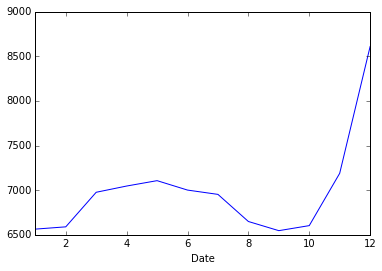

In [106]:
concat.groupby('Date2')['Sales'].mean().plot()

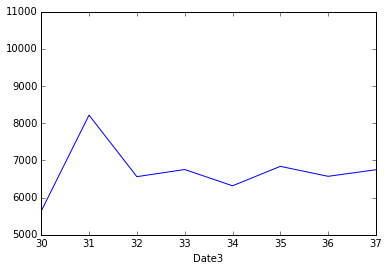

In [122]:
concat.groupby('SchoolHoliday')['Sales'].mean()


SchoolHoliday
0    6896.782411
1    7200.181650
Name: Sales, dtype: float64

In [125]:
concat.groupby('StateHoliday2')['Sales'].mean()


StateHoliday2
0    6953.515034
1    8487.471182
2    9887.889655
3    9743.746479
Name: Sales, dtype: float64

In [58]:
test.groupby('StateHoliday').size()

StateHoliday
0    40908
a      180
dtype: int64